In [1]:
import cobra
import numpy as np
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary
from eflux2 import eflux2
from create_flux_solution_df import create_flux_solution_df
from add_column_to_13c_flux_df import add_column_to_13c_flux_df
from flux_prediction_scatterplot import flux_prediction_scatterplot


### Load genome scale model

In [2]:
model = cobra.io.json.load_json_model("../genome_scale_models/iYLI647_corr_2.json")
model

Name,model
Memory address,1180c78e0
Number of metabolites,1121
Number of reactions,1348
Number of genes,648
Number of groups,0
Objective expression,1.0*biomass_C - 1.0*biomass_C_reverse_c1d5c
Compartments,"c, e, m, n, x, r, g, v"


### Load transcriptomics data

In [3]:
# load this file data/transcriptomics/fpkm_counts.csv
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [4]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [5]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Run E-Flux2 for Glucose 1

In [6]:
glucose_medium = {
    'EX_glc(e)': np.inf,
    'EX_h2o(e)': 1000.0,
    'EX_h(e)': 1000.0,
    'EX_nh4(e)': 1000.0,
    'EX_o2(e)': 1000.0,
    'EX_pi(e)': 1000.0,
    'EX_so4(e)': 1000.0,
}

# run eflux2 for glucose_1
glucose_1_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glucose_1_reaction_transcripts, 
    medium=glucose_medium, 
    carbon_uptake_reaction='EX_glc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glucose_1_eflux2_solution_df = create_flux_solution_df(model, glucose_1_eflux2_solution)

# save the dataframe to a csv file
glucose_1_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glucose_1_gsm_eflux2.csv', index=False)

display(glucose_1_eflux2_solution_df.head(30))

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-666.959559
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.566172
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.261313
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.261313
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-320.522192
421,EX_h2o(e),H2O exchange,h2o[e] <=>,320.522192
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,316.638002
639,NADH2_u6cm,NADH dehydrogenase cytosolicmitochondrial,h[c] + nadh[c] + q6[m] --> nad[c] + q6h2[m],281.289436
291,GLUDy,glutamate dehydrogenase NADP,glu_L[c] + h2o[c] + nadp[c] <=> akg[c] + h[c] ...,-187.019702
391,EX_co2(e),CO2 exchange,co2[e] -->,184.301252


### Run E-Flux2 for Glucose 2

In [7]:
# run eflux2 for glucose_2
glucose_2_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glucose_2_reaction_transcripts, 
    medium=glucose_medium, 
    carbon_uptake_reaction='EX_glc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glucose_2_eflux2_solution_df = create_flux_solution_df(model, glucose_2_eflux2_solution)

# save the dataframe to a csv file
glucose_2_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glucose_2_gsm_eflux2.csv', index=False)

display(glucose_2_eflux2_solution_df.head(30))

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-667.557678
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.662025
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.378556
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.378556
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-316.963941
421,EX_h2o(e),H2O exchange,h2o[e] <=>,316.963941
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,316.873988
639,NADH2_u6cm,NADH dehydrogenase cytosolicmitochondrial,h[c] + nadh[c] + q6[m] --> nad[c] + q6h2[m],282.104852
957,CO2t,CO2 transporter via diffusion,co2[e] <=> co2[c],-185.010774
391,EX_co2(e),CO2 exchange,co2[e] -->,185.010774


### Run E-Flux2 for Glucose 3

In [8]:
# run eflux2 for glucose_3
glucose_3_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glucose_3_reaction_transcripts, 
    medium=glucose_medium, 
    carbon_uptake_reaction='EX_glc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glucose_3_eflux2_solution_df = create_flux_solution_df(model, glucose_3_eflux2_solution)

# save the dataframe to a csv file
glucose_3_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glucose_3_gsm_eflux2.csv', index=False)

display(glucose_3_eflux2_solution_df.head(30))

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-667.221169
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,366.608097
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],365.312594
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],365.312594
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-318.965861
421,EX_h2o(e),H2O exchange,h2o[e] <=>,318.965861
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,316.741219
639,NADH2_u6cm,NADH dehydrogenase cytosolicmitochondrial,h[c] + nadh[c] + q6[m] --> nad[c] + q6h2[m],281.646088
391,EX_co2(e),CO2 exchange,co2[e] -->,184.611587
957,CO2t,CO2 transporter via diffusion,co2[e] <=> co2[c],-184.611587


### Glucose Central Metabolism E-Flux2

In [9]:
# load glucose 13C MFA data
glucose_13c_mfa_df = pd.read_csv('../data/13c_mfa/glucose_13c_mfa.csv')

# only keep the reactions that are mapped to the GSM
glucose_13c_mfa_df.dropna(subset = ["reaction_ids"], inplace=True)

# add the GSM flux predictions to the 13C-MFA dataframe
glucose_central_eflux2_df = add_column_to_13c_flux_df(glucose_13c_mfa_df, glucose_1_eflux2_solution_df, 'Glucose 1 Flux')
glucose_central_eflux2_df = add_column_to_13c_flux_df(glucose_central_eflux2_df, glucose_2_eflux2_solution_df, 'Glucose 2 Flux')
glucose_central_eflux2_df = add_column_to_13c_flux_df(glucose_central_eflux2_df, glucose_3_eflux2_solution_df, 'Glucose 3 Flux')

# add a columns for the average and standard deviation of the three flux predictions
glucose_central_eflux2_df['E-Flux2 Flux'] = glucose_central_eflux2_df[['Glucose 1 Flux', 'Glucose 2 Flux', 'Glucose 3 Flux']].mean(axis=1)
glucose_central_eflux2_df['E-Flux2 Flux Std'] = glucose_central_eflux2_df[['Glucose 1 Flux', 'Glucose 2 Flux', 'Glucose 3 Flux']].std(axis=1)

# save the central fluxes as .csv
glucose_central_eflux2_df.to_csv('../results/eflux2_central_fluxes/glucose_central_eflux2.csv', index=False)

glucose_central_eflux2_df

,pathway,compartment,Equation,reaction_ids,13C_mfa_flux,StdErr,13C_mfa_flux_95%_lower_bound,13C_mfa_flux_95%_upper_bound,Glucose 1 Flux,Glucose 2 Flux,Glucose 3 Flux,E-Flux2 Flux,E-Flux2 Flux Std
0,substrate_uptake,cytosol,Glucose + ATP -> G6P,reverse_EX_glc(e),1.000000e+02,1.000000e-01,9.980400e+01,100.1960,1.000000e+02,100.000000,100.000000,1.000000e+02,0.000000e+00
1,emp,cytosol,G6P <-> F6P,PGI,2.635690e+01,1.740600e+00,2.082870e+01,29.7882,-4.354580e+01,-44.923378,-44.148332,-4.420584e+01,6.905885e-01
2,emp,cytosol,F6P + ATP <-> FBP,PFK or reverse_FBP,6.530620e+01,6.654000e-01,6.344250e+01,67.9137,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
3,emp,cytosol,FBP <-> DHAP + GAP,FBA,6.530620e+01,6.654000e-01,6.344250e+01,67.9137,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
4,emp,cytosol,DHAP <-> GAP,TPI,6.529770e+01,6.641000e-01,6.343470e+01,67.9034,2.307489e+01,21.057458,22.192491,2.210828e+01,1.011348e+00
5,emp,cytosol,GAP <-> G3P + ATP + NADH,GAPD,1.492144e+02,9.235000e-01,1.473067e+02,155.5588,9.697373e+01,95.384146,96.278467,9.621211e+01,7.968659e-01
6,emp,cytosol,G3P <-> PEP,ENO,1.473693e+02,9.699000e-01,1.435083e+02,154.1212,8.852677e+01,87.075647,87.892067,8.783149e+01,7.274544e-01
7,emp,cytosol,PEP <-> PYRcyt + ATP,PYK,1.401666e+02,1.107200e+00,1.362425e+02,763.1491,8.590781e+01,84.499623,85.291890,8.523311e+01,7.059335e-01
8,pentose_phosphate,cytosol,G6P -> PG6 + NADPH,G6PDH2,6.654930e+01,1.722800e+00,6.027170e+01,72.0662,1.327573e+02,134.311730,133.437190,1.335021e+02,7.792411e-01
9,pentose_phosphate,cytosol,PG6 -> P5P + CO2 + NADPH,GND,6.654930e+01,1.722800e+00,6.027170e+01,72.0662,1.335214e+02,135.063340,134.195847,1.342602e+02,7.729620e-01


### Plot Glucose E-Flux2 Results

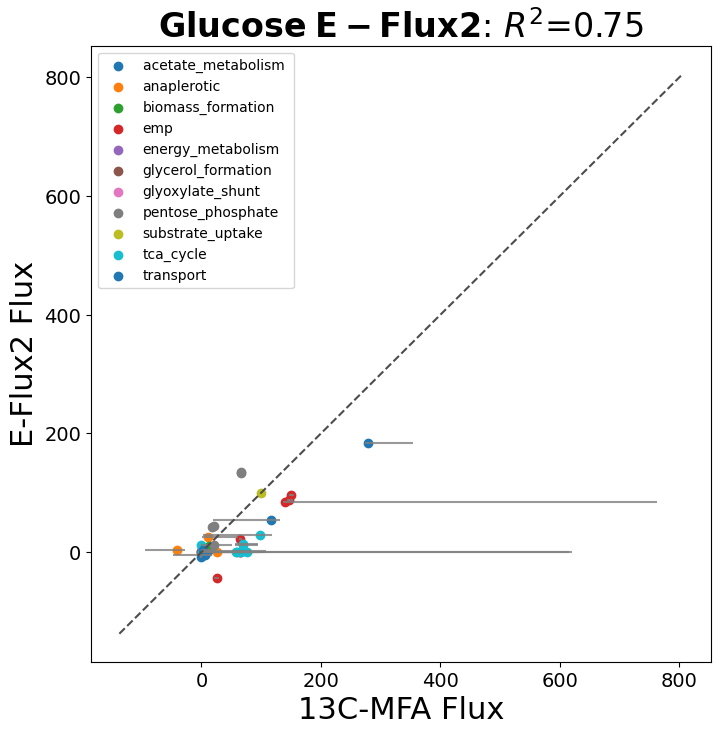

In [10]:
flux_prediction_scatterplot(
    fluxes_df=glucose_central_eflux2_df, 
    substrate='Glucose',
    method='E-Flux2',
    # range=(-100, 400)   
)

### Run E-Flux2 for Glycerol 1

In [11]:
glycerol_medium = {
    'EX_glyc(e)': np.inf,
    'EX_h2o(e)': 1000.0,
    'EX_h(e)': 1000.0,
    'EX_nh4(e)': 1000.0,
    'EX_o2(e)': 1000.0,
    'EX_pi(e)': 1000.0,
    'EX_so4(e)': 1000.0,
}

# run eflux2 for glycerol_1
glycerol_1_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glycerol_1_reaction_transcripts, 
    medium=glycerol_medium, 
    carbon_uptake_reaction='EX_glyc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glycerol_1_eflux2_solution_df = create_flux_solution_df(model, glycerol_1_eflux2_solution)

# save the dataframe to a csv file
glycerol_1_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glycerol_1_gsm_eflux2.csv', index=False)

glycerol_1_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-432.201100
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,249.927329
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],249.651098
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],226.995975
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-220.541970
421,EX_h2o(e),H2O exchange,h2o[e] <=>,220.541970
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,206.615100
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],145.185610
444,EX_o2(e),O2 exchange,o2[e] <=>,-145.185610
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],131.563311


### Run E-Flux2 for Glycerol 2

In [12]:
# run eflux2 for glycerol_2
glycerol_2_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glycerol_2_reaction_transcripts, 
    medium=glycerol_medium, 
    carbon_uptake_reaction='EX_glyc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glycerol_2_eflux2_solution_df = create_flux_solution_df(model, glycerol_2_eflux2_solution)

# save the dataframe to a csv file
glycerol_2_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glycerol_2_gsm_eflux2.csv', index=False)

glycerol_2_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-430.419575
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,252.569690
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],244.710288
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],222.293524
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-221.317091
421,EX_h2o(e),H2O exchange,h2o[e] <=>,221.317091
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,207.386691
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],146.458988
444,EX_o2(e),O2 exchange,o2[e] <=>,-146.458988
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],130.182383


### Run E-Flux2 for Glycerol 3

In [13]:
# run eflux2 for glycerol_3
glycerol_3_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=glycerol_3_reaction_transcripts, 
    medium=glycerol_medium, 
    carbon_uptake_reaction='EX_glyc(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
glycerol_3_eflux2_solution_df = create_flux_solution_df(model, glycerol_3_eflux2_solution)

# save the dataframe to a csv file
glycerol_3_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/glycerol_3_gsm_eflux2.csv', index=False)

glycerol_3_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-413.138609
421,EX_h2o(e),H2O exchange,h2o[e] <=>,251.645205
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-251.645205
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,245.228070
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],231.917496
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],212.140168
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,200.463288
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],142.269629
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],114.446234
444,EX_o2(e),O2 exchange,o2[e] <=>,-114.446234


### Glycerol Central Metabolism E-Flux2

In [14]:
# load glycerol 13C MFA data
glycerol_13c_mfa_df = pd.read_csv('../data/13c_mfa/glycerol_13c_mfa.csv')

# only keep the reactions that are mapped to the GSM
glycerol_13c_mfa_df.dropna(subset = ["reaction_ids"], inplace=True)

# add the GSM flux predictions to the 13C-MFA dataframe
glycerol_central_eflux2_df = add_column_to_13c_flux_df(glycerol_13c_mfa_df, glycerol_1_eflux2_solution_df, 'Glycerol 1 Flux')
glycerol_central_eflux2_df = add_column_to_13c_flux_df(glycerol_central_eflux2_df, glycerol_2_eflux2_solution_df, 'Glycerol 2 Flux')
glycerol_central_eflux2_df = add_column_to_13c_flux_df(glycerol_central_eflux2_df, glycerol_3_eflux2_solution_df, 'Glycerol 3 Flux')

# add a columns for the average and standard deviation of the three flux predictions
glycerol_central_eflux2_df['E-Flux2 Flux'] = glycerol_central_eflux2_df[['Glycerol 1 Flux', 'Glycerol 2 Flux', 'Glycerol 3 Flux']].mean(axis=1)
glycerol_central_eflux2_df['E-Flux2 Flux Std'] = glycerol_central_eflux2_df[['Glycerol 1 Flux', 'Glycerol 2 Flux', 'Glycerol 3 Flux']].std(axis=1)

# save the central fluxes as .csv
glycerol_central_eflux2_df.to_csv('../results/eflux2_central_fluxes/glycerol_central_eflux2.csv', index=False)

glycerol_central_eflux2_df

,pathway,compartment,Equation,reaction_ids,13C_mfa_flux,StdErr,13C_mfa_flux_95%_lower_bound,13C_mfa_flux_95%_upper_bound,Glycerol 1 Flux,Glycerol 2 Flux,Glycerol 3 Flux,E-Flux2 Flux,E-Flux2 Flux Std
0,substrate_uptake,cytosol,Glycerol -> GLYC,reverse_GLYCt,1.000000e+02,4.760000e-09,100.0000,100.0000,100.000000,100.000000,100.000000,100.000000,1.004859e-14
3,emp,cytosol,G6P <-> F6P,PGI,-9.094400e+00,3.915980e+01,-21.4029,0.0000,-2.283861,-2.295899,-2.797663,-2.459141,2.932300e-01
4,emp,cytosol,F6P + ATP <-> FBP,PFK or reverse_FBP,-5.336800e+00,1.282410e+01,-9.3768,-2.2568,-32.316964,-32.931868,-15.261193,-26.836675,1.002938e+01
5,emp,cytosol,FBP <-> DHAP + GAP,FBA,-5.336800e+00,1.282410e+01,-9.3768,-2.2568,-32.316964,-32.931868,-15.261193,-26.836675,1.002938e+01
6,emp,cytosol,DHAP <-> GAP,TPI,9.466320e+01,1.282410e+01,90.5337,97.7431,67.466280,66.850233,84.473286,72.929933,1.000158e+01
7,emp,cytosol,GAP <-> G3P + ATP + NADH,GAPD,8.980640e+01,1.234150e+01,85.8134,92.9900,61.835519,61.189792,76.980173,66.668495,8.936010e+00
8,emp,cytosol,G3P <-> PEP,ENO,8.511740e+01,1.184310e+01,81.1338,88.5232,21.139391,19.390030,57.244894,32.591438,2.136843e+01
9,emp,cytosol,PEP <-> PYRcyt + ATP,PYK,7.791050e+01,1.112890e+01,73.9732,606.6294,20.584973,18.832690,56.565749,31.994471,2.129738e+01
10,pentose_phosphate,cytosol,G6P -> PG6 + NADPH,G6PDH2,9.094400e+00,3.915980e+01,0.0000,21.4029,0.000000,0.000000,0.000000,0.000000,0.000000e+00
11,pentose_phosphate,cytosol,PG6 -> P5P + CO2 + NADPH,GND,9.094400e+00,3.915980e+01,0.0000,21.4029,0.161763,0.162616,0.198155,0.174178,2.076913e-02


### Plot Glycerol E-Flux2 Results

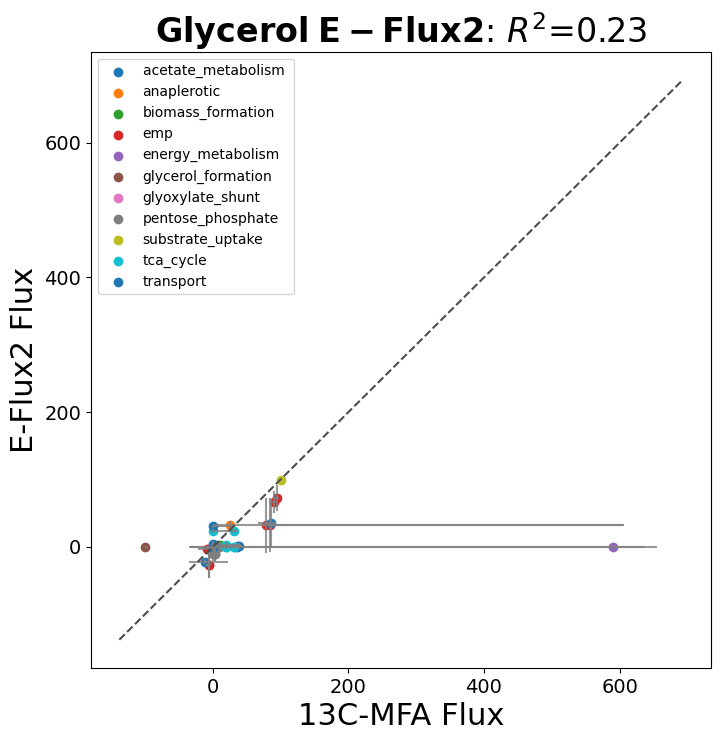

In [15]:
flux_prediction_scatterplot(
    fluxes_df=glycerol_central_eflux2_df, 
    substrate='Glycerol',
    method='E-Flux2',
    # range=(-150, 600)   
)

### Run E-Flux2 for Oleic Acid 1

In [16]:
oleic_acid_medium = {
    'EX_ocdcea(e)': np.inf,
    'EX_h2o(e)': 1000.0,
    'EX_h(e)': 1000.0,
    'EX_nh4(e)': 1000.0,
    'EX_o2(e)': 1000.0,
    'EX_pi(e)': 1000.0,
    'EX_so4(e)': 1000.0,
}

# run eflux2 for oleic_acid_1
oleic_acid_1_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=oleic_acid_1_reaction_transcripts, 
    medium=oleic_acid_medium, 
    carbon_uptake_reaction='EX_ocdcea(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
oleic_acid_1_eflux2_solution_df = create_flux_solution_df(model, oleic_acid_1_eflux2_solution)

# save the dataframe to a csv file
oleic_acid_1_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/oleic_acid_1_gsm_eflux2.csv', index=False)

oleic_acid_1_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3041.050412
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2194.068288
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2190.428963
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2190.428963
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,2099.879235
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],1405.430375
444,EX_o2(e),O2 exchange,o2[e] <=>,-1405.430375
609,CYOOm,cytochrome c oxidase mitochondrial,4.0 focytc[m] + 6.0 h[m] + o2[m] --> 4.0 ficyt...,1049.939618
1016,O2tm,O2 transport diffusion,o2[c] <=> o2[m],1049.939618
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],1029.211362


### Run E-Flux2 for Oleic Acid 2

In [17]:
# run eflux2 for oleic_acid_2
oleic_acid_2_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=oleic_acid_2_reaction_transcripts, 
    medium=oleic_acid_medium, 
    carbon_uptake_reaction='EX_ocdcea(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
oleic_acid_2_eflux2_solution_df = create_flux_solution_df(model, oleic_acid_2_eflux2_solution)

# save the dataframe to a csv file
oleic_acid_2_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/oleic_acid_2_gsm_eflux2.csv', index=False)

oleic_acid_2_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3041.050412
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2194.068288
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2190.428963
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2190.428963
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,2099.879235
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],1405.430375
444,EX_o2(e),O2 exchange,o2[e] <=>,-1405.430375
609,CYOOm,cytochrome c oxidase mitochondrial,4.0 focytc[m] + 6.0 h[m] + o2[m] --> 4.0 ficyt...,1049.939618
1016,O2tm,O2 transport diffusion,o2[c] <=> o2[m],1049.939618
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],1029.211362


### Run E-Flux2 for Oleic Acid 3

In [18]:
# run eflux2 for oleic_acid_3
oleic_acid_3_eflux2_solution = eflux2(
    model=model, 
    reaction_transcript_dictionary=oleic_acid_3_reaction_transcripts, 
    medium=oleic_acid_medium, 
    carbon_uptake_reaction='EX_ocdcea(e)', 
    carbon_uptake_flux=100
)

# create a dataframe from the eflux2 solution
oleic_acid_3_eflux2_solution_df = create_flux_solution_df(model, oleic_acid_3_eflux2_solution)

# save the dataframe to a csv file
oleic_acid_3_eflux2_solution_df.to_csv('../results/eflux2_gsm_fluxes/oleic_acid_3_gsm_eflux2.csv', index=False)

oleic_acid_3_eflux2_solution_df.head(30)

,reaction_id,reaction_name,full_reaction,flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3041.050412
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2194.068288
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2190.428963
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2190.428963
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,2099.879235
964,O2t,o2 transport diffusion,o2[e] <=> o2[c],1405.430375
444,EX_o2(e),O2 exchange,o2[e] <=>,-1405.430375
1016,O2tm,O2 transport diffusion,o2[c] <=> o2[m],1049.939618
609,CYOOm,cytochrome c oxidase mitochondrial,4.0 focytc[m] + 6.0 h[m] + o2[m] --> 4.0 ficyt...,1049.939618
846,NADH2_u6m,NADH dehydrogenase mitochondrial,h[m] + nadh[m] + q6[m] --> nad[m] + q6h2[m],1029.211362


### Oleic Acid Central Metabolism E-Flux2

In [19]:
# load oleic acid 13C MFA data
oleic_acid_13c_mfa_df = pd.read_csv('../data/13c_mfa/oleic_acid_900_13c_mfa.csv')

# only keep the reactions that are mapped to the GSM
oleic_acid_13c_mfa_df.dropna(subset = ["reaction_ids"], inplace=True)

# add the GSM flux predictions to the 13C-MFA dataframe
oleic_acid_central_eflux2_df = add_column_to_13c_flux_df(oleic_acid_13c_mfa_df, oleic_acid_1_eflux2_solution_df, 'Oleic Acid 1 Flux')
oleic_acid_central_eflux2_df = add_column_to_13c_flux_df(oleic_acid_central_eflux2_df, oleic_acid_2_eflux2_solution_df, 'Oleic Acid 2 Flux')
oleic_acid_central_eflux2_df = add_column_to_13c_flux_df(oleic_acid_central_eflux2_df, oleic_acid_3_eflux2_solution_df, 'Oleic Acid 3 Flux')

# add a columns for the average and standard deviation of the three flux predictions
oleic_acid_central_eflux2_df['E-Flux2 Flux'] = oleic_acid_central_eflux2_df[['Oleic Acid 1 Flux', 'Oleic Acid 2 Flux', 'Oleic Acid 3 Flux']].mean(axis=1)
oleic_acid_central_eflux2_df['E-Flux2 Flux Std'] = oleic_acid_central_eflux2_df[['Oleic Acid 1 Flux', 'Oleic Acid 2 Flux', 'Oleic Acid 3 Flux']].std(axis=1)

# save the central fluxes as .csv
oleic_acid_central_eflux2_df.to_csv('../results/eflux2_central_fluxes/oleic_acid_central_eflux2.csv', index=False)

oleic_acid_central_eflux2_df

,pathway,compartment,Equation,reaction_ids,13C_mfa_flux,StdErr,13C_mfa_flux_95%_lower_bound,13C_mfa_flux_95%_upper_bound,Oleic Acid 1 Flux,Oleic Acid 2 Flux,Oleic Acid 3 Flux,E-Flux2 Flux,E-Flux2 Flux Std
0,substrate_uptake,cytosol,Oleic Acid -> 9 AC,OCDCEAt,1.000000e+02,6.540000e-11,1.000000e+02,100.0000,100.000000,100.000000,100.000000,100.000000,0.000000e+00
1,emp,cytosol,G6P <-> F6P,PGI,-1.923834e+02,1.445210e+01,-2.594513e+02,0.0000,-30.089725,-30.089725,-30.089725,-30.089725,8.202076e-14
2,emp,cytosol,F6P + ATP <-> FBP,PFK or reverse_FBP,-7.590870e+01,5.702400e+00,-9.804160e+01,-6.9760,-68.054033,-68.054033,-68.054033,-68.054033,7.176130e-14
3,emp,cytosol,FBP <-> DHAP + GAP,FBA,-7.590870e+01,5.702400e+00,-9.804160e+01,-6.9760,-68.054033,-68.054033,-68.054033,-68.054033,8.101434e-14
4,emp,cytosol,DHAP <-> GAP,TPI,-7.590870e+01,5.702400e+00,-3.377775e+02,-13.5021,-70.909786,-70.909786,-70.909786,-70.909786,1.086921e-13
5,emp,cytosol,GAP <-> G3P + ATP + NADH,GAPD,-1.007287e+02,7.566900e+00,-2.443168e+02,-41.9351,-143.707423,-143.707423,-143.707423,-143.707423,1.569640e-13
6,emp,cytosol,G3P <-> PEP,ENO,-1.289800e+02,9.689200e+00,-3.426249e+02,-42.6334,-143.707423,-143.707423,-143.707423,-143.707423,1.476835e-13
7,emp,cytosol,PEP <-> PYRcyt + ATP,PYK,3.372210e+01,2.525395e+02,NaN,1580.0000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
8,pentose_phosphate,cytosol,G6P -> PG6 + NADPH,G6PDH2,1.923834e+02,1.445210e+01,0.000000e+00,259.4513,0.000000,0.000000,0.000000,0.000000,0.000000e+00
9,pentose_phosphate,cytosol,PG6 -> P5P + CO2 + NADPH,GND,1.923834e+02,1.445210e+01,0.000000e+00,259.4513,2.131219,2.131219,2.131219,2.131219,5.916562e-15


### Plot Oleic Acid E-Flux2 Results

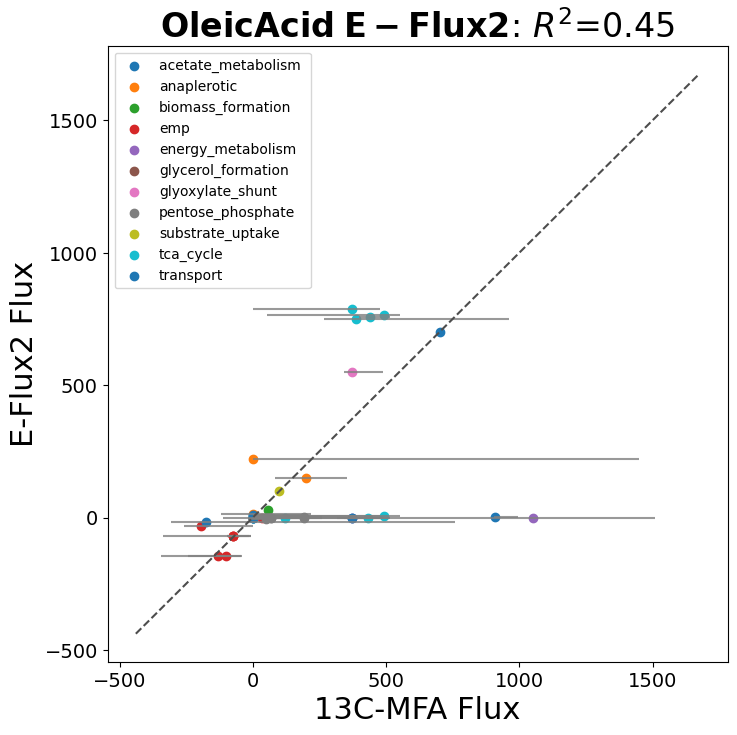

In [20]:
flux_prediction_scatterplot(
    fluxes_df=oleic_acid_central_eflux2_df, 
    substrate='Oleic Acid',
    method='E-Flux2',
    # range=(-300, 1200)   
)

### Investigate carbon flow in glucose condition

In [21]:
glucose_1_eflux2_solution

,fluxes,reduced_costs
13BGH,0.000000,49.701149
13BGHe,0.000000,-2.000000
ASADi,5.407341,-2.000000
2DDA7Ptm,0.000000,2.000000
2DHPtm,0.000000,-2.000000
...,...,...
erythroseS,0.000000,2.000000
erythritolS,0.000000,2.000000
erythritolT,0.000000,2.000000
EX_eryth(e),0.000000,44.666667


In [22]:
# get the reactions that are not zero for a metabolite from a dataframe
def get_consuming_producing_fluxes_for_metabolite(df, metabolite_id):
  metabolite = model.metabolites.get_by_id(metabolite_id)

  producing_reactions = pd.DataFrame()
  consuming_reactions =  pd.DataFrame()

  # loop over the reactions that the metabolite is involved in
  for r in metabolite.reactions:

    # get the flux of the reaction from the solution dataframe
    reaction_id = r.id
    reaction_row = df.loc[df['reaction_id'] == reaction_id]
    flux = reaction_row['flux'].iloc[0]

    FLUX_CUTOFF = 0.001

    if abs(flux) < FLUX_CUTOFF:
      continue

    elif flux > FLUX_CUTOFF and metabolite in r.products:
      # add the reaction_row to the producing dataframe
      producing_reactions = pd.concat([producing_reactions, reaction_row])

    elif flux > FLUX_CUTOFF and metabolite in r.reactants:
      # add the reaction_row to the consuming dataframe
      consuming_reactions = pd.concat([consuming_reactions, reaction_row])

    elif flux < FLUX_CUTOFF and metabolite in r.products:
      # add the reaction_row to the consuming dataframe
      consuming_reactions = pd.concat([consuming_reactions, reaction_row])

    elif flux < FLUX_CUTOFF and metabolite in r.reactants:
      # add the reaction_row to the producing dataframe
      producing_reactions = pd.concat([producing_reactions, reaction_row])

  return {
    'name': metabolite.name,
    'id': metabolite.id,
    'compartment': metabolite.compartment,
    'consuming_reactions': consuming_reactions,
    'producing_reactions': producing_reactions
  }

def make_metabolite_flux_list(df, metabolite_ids):
  fluxes_for_metabolites = []

  for metabolite_id in metabolite_ids:
    fluxes_for_metabolites.append(get_consuming_producing_fluxes_for_metabolite(df, metabolite_id))

  return fluxes_for_metabolites

def print_flux_pathway(flux_pathway):

  for metabolite in flux_pathway:
    print(f"Metabolite: {metabolite['name']}"),
    print(f"Metabolite id: {metabolite['id']}")

    print('producing reactions')
    display(metabolite['producing_reactions'])

    print('consuming reactions')
    display(metabolite['consuming_reactions'])

    print()

In [23]:
# list of the relevant metabolites in order of the pathway
metabolite_list = [
  'glc_D[e]', 'glc_D[c]', 'g6p[c]', 'f6p[c]', 'fdp[c]', 'dhap[c]', 'g3p[c]', '3pg[c]', '13dpg[c]', '2pg[c]', 'pep[c]', 'pyr[c]', # glycolysis
  '6pgl[c]', '6pgc[c]', 'ru5p_D[c]', 'xu5p_D[c]', 'r5p[c]', 's7p[c]', 'e4p[c]', 'dhap[c]' # pentose phosphate pathway
  # 'pyr[m]', 'alac_S[m]', '23dhmb[m]', '3mob[m]', '3c3hmp[m]', '3c3hmp[c]', '2ippm[c]', # intermediate metabolites
  # '3c2hmp[c]', '3c4mop[c]', '4mop[c]', 'ivcoa[c]', '3mb2coa[c]', '3mgcoa[c]', # intermediate metabolites
  # 'hmgcoa[c]', 'mev_R[c]', '5pmev[c]', '5dpmev[c]', 'ipdp[c]', 'dmpp[c]', 'grdp[c]', 'frdp[c]' # mevalonate pathway
]

# get the fluxes for the metabolites in the pathway
glucose_to_farnesyl_diphosphate_pathway = make_metabolite_flux_list(glucose_1_eflux2_solution_df, metabolite_list)
print_flux_pathway(glucose_to_farnesyl_diphosphate_pathway)

Metabolite: D_Glucose
Metabolite id: glc_D[e]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
413,EX_glc(e),D Glucose exchange,glc_D[e] <=>,-100.0


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
958,GLCt1,glucose transport uniport,glc_D[e] --> glc_D[c],100.0



Metabolite: D_Glucose
Metabolite id: glc_D[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
958,GLCt1,glucose transport uniport,glc_D[e] --> glc_D[c],100.0


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
711,HEX1,hexokinase D glucoseATP,atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c],100.0



Metabolite: D_Glucose_6_phosphate
Metabolite id: g6p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
547,PGI,glucose 6 phosphate isomerase,g6p[c] <=> f6p[c],-43.545797
711,HEX1,hexokinase D glucoseATP,atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c],100.000000


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
39,TRE6PS,alpha alpha trehalose phosphate synthase UDP f...,g6p[c] + udpg[c] --> h[c] + tre6p[c] + udp[c],0.071288
933,G6Pter,glucose 6 phosphate endoplasmic reticular tran...,g6p[c] <=> g6p[r],0.764136
651,PGMT,phosphoglucomutase,g1p[c] <=> g6p[c],-9.875127
605,G6PDH2,glucose 6 phosphate dehydrogenase,g6p[c] + nadp[c] --> 6pgl[c] + h[c] + nadph[c],132.757305
831,MI1PS,myo Inositol 1 phosphate synthase,g6p[c] --> mi1p_D[c],0.077940



Metabolite: D_Fructose_6_phosphate
Metabolite id: f6p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
690,TKT2,transketolase,e4p[c] + xu5p_D[c] <=> f6p[c] + g3p[c],42.529255
1124,TALA,transaldolase,g3p[c] + s7p[c] <=> e4p[c] + f6p[c],12.491535


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
280,MAN6PI,mannose 6 phosphate isomerase,man6p[c] <=> f6p[c],-2.450960
547,PGI,glucose 6 phosphate isomerase,g6p[c] <=> f6p[c],-43.545797
632,GF6PTA,glutamine fructose 6 phosphate transaminase,f6p[c] + gln_L[c] --> gam6p[c] + glu_L[c],9.024034



Metabolite: D_Fructose_1_6_bisphosphate
Metabolite id: fdp[c]
producing reactions


""


consuming reactions


""



Metabolite: Dihydroxyacetone_phosphate
Metabolite id: dhap[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
571,FBA3,Sedoheptulose 1 7 bisphosphate D glyceraldehyd...,s17bp[c] <=> dhap[c] + e4p[c],31.347197


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
620,GAT2_SC,glycerol 3 phosphate acyltransferase glycerone...,0.02 dcacoa[c] + 0.06 ddcacoa[c] + dhap[c] + 0...,8.272381
561,TPI,triose phosphate isomerase,dhap[c] <=> g3p[c],23.074888



Metabolite: Glyceraldehyde_3_phosphate
Metabolite id: g3p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
690,TKT2,transketolase,e4p[c] + xu5p_D[c] <=> f6p[c] + g3p[c],42.529255
561,TPI,triose phosphate isomerase,dhap[c] <=> g3p[c],23.074888
1113,TRPS1,tryptophan synthase indoleglycerol phosphate,3ig3p[c] + ser_L[c] --> g3p[c] + h2o[c] + trp_...,0.022389
1144,TKT1,transketolase,r5p[c] + xu5p_D[c] <=> g3p[c] + s7p[c],43.838732


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
330,GAPD,glyceraldehyde 3 phosphate dehydrogenase,g3p[c] + nad[c] + pi[c] <=> 13dpg[c] + h[c] + ...,96.973729
1124,TALA,transaldolase,g3p[c] + s7p[c] <=> e4p[c] + f6p[c],12.491535



Metabolite: 3_Phospho_D_glycerate
Metabolite id: 3pg[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
550,PGK,phosphoglycerate kinase,3pg[c] + atp[c] <=> 13dpg[c] + adp[c],-96.973729


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
311,PGCD,phosphoglycerate dehydrogenase,3pg[c] + nad[c] --> 3php[c] + h[c] + nadh[c],8.446961
553,PGM,phosphoglycerate mutase,2pg[c] <=> 3pg[c],-88.526768



Metabolite: 3_Phospho_D_glyceroyl_phosphate
Metabolite id: 13dpg[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
330,GAPD,glyceraldehyde 3 phosphate dehydrogenase,g3p[c] + nad[c] + pi[c] <=> 13dpg[c] + h[c] + ...,96.973729


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
550,PGK,phosphoglycerate kinase,3pg[c] + atp[c] <=> 13dpg[c] + adp[c],-96.973729



Metabolite: D_Glycerate_2_phosphate
Metabolite id: 2pg[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
553,PGM,phosphoglycerate mutase,2pg[c] <=> 3pg[c],-88.526768


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
317,ENO,enolase,2pg[c] <=> h2o[c] + pep[c],88.526768



Metabolite: Phosphoenolpyruvate
Metabolite id: pep[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
317,ENO,enolase,2pg[c] <=> h2o[c] + pep[c],88.526768


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
1110,PSCVTi,3 phosphoshikimate 1 carboxyvinyltransferase i...,pep[c] + skm5p[c] --> 3psme[c] + pi[c],1.309477
557,PYK,pyruvate kinase,adp[c] + h[c] + pep[c] --> atp[c] + pyr[c],85.907814
1080,DDPA,3 deoxy D arabino heptulosonate 7 phosphate sy...,e4p[c] + h2o[c] + pep[c] --> 2dda7p[c] + pi[c],1.309477



Metabolite: Pyruvate
Metabolite id: pyr[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
294,ANS,anthranilate synthase,chor[c] + gln_L[c] --> anth[c] + glu_L[c] + h[...,0.022389
557,PYK,pyruvate kinase,adp[c] + h[c] + pep[c] --> atp[c] + pyr[c],85.907814


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
1020,PYRt2m,pyruvate mitochondrial transport via proton sy...,h[c] + pyr[c] <=> h[m] + pyr[m],55.011928
114,ALATA_L,L alanine transaminase,akg[c] + ala_L[c] <=> glu_L[c] + pyr[c],-5.902054
47,PC,pyruvate carboxylase,atp[c] + hco3[c] + pyr[c] --> adp[c] + h[c] + ...,25.016221



Metabolite: 6_phospho_D_glucono_1_5_lactone
Metabolite id: 6pgl[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
605,G6PDH2,glucose 6 phosphate dehydrogenase,g6p[c] + nadp[c] --> 6pgl[c] + h[c] + nadph[c],132.757305
30,6PGLter,6 phospho D glucono 1 5 lactone endoplasmic re...,6pgl[c] <=> 6pgl[r],-0.764136


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
650,PGL,6 phosphogluconolactonase,6pgl[c] + h2o[c] --> 6pgc[c] + h[c],133.521441



Metabolite: 6_Phospho_D_gluconate
Metabolite id: 6pgc[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
650,PGL,6 phosphogluconolactonase,6pgl[c] + h2o[c] --> 6pgc[c] + h[c],133.521441


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
646,GND,phosphogluconate dehydrogenase,6pgc[c] + nadp[c] --> co2[c] + nadph[c] + ru5p...,133.521441



Metabolite: D_Ribulose_5_phosphate
Metabolite id: ru5p_D[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
646,GND,phosphogluconate dehydrogenase,6pgc[c] + nadp[c] --> co2[c] + nadph[c] + ru5p...,133.521441


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
672,RPE,ribulose 5 phosphate 3 epimerase,ru5p_D[c] <=> xu5p_D[c],86.367987
687,RPI,ribose 5 phosphate isomerase,r5p[c] <=> ru5p_D[c],-47.153454



Metabolite: D_Xylulose_5_phosphate
Metabolite id: xu5p_D[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
672,RPE,ribulose 5 phosphate 3 epimerase,ru5p_D[c] <=> xu5p_D[c],86.367987


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
690,TKT2,transketolase,e4p[c] + xu5p_D[c] <=> f6p[c] + g3p[c],42.529255
1144,TKT1,transketolase,r5p[c] + xu5p_D[c] <=> g3p[c] + s7p[c],43.838732



Metabolite: alpha_D_Ribose_5_phosphate
Metabolite id: r5p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
687,RPI,ribose 5 phosphate isomerase,r5p[c] <=> ru5p_D[c],-47.153454


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
1144,TKT1,transketolase,r5p[c] + xu5p_D[c] <=> g3p[c] + s7p[c],43.838732
1014,PRPPS,phosphoribosylpyrophosphate synthetase,atp[c] + r5p[c] <=> amp[c] + h[c] + prpp[c],3.314722



Metabolite: Sedoheptulose_7_phosphate
Metabolite id: s7p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
1144,TKT1,transketolase,r5p[c] + xu5p_D[c] <=> g3p[c] + s7p[c],43.838732


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
1124,TALA,transaldolase,g3p[c] + s7p[c] <=> e4p[c] + f6p[c],12.491535
954,PFK_3,phosphofructokinase s7p,atp[c] + s7p[c] --> adp[c] + h[c] + s17bp[c],31.347197



Metabolite: D_Erythrose_4_phosphate
Metabolite id: e4p[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
1124,TALA,transaldolase,g3p[c] + s7p[c] <=> e4p[c] + f6p[c],12.491535
571,FBA3,Sedoheptulose 1 7 bisphosphate D glyceraldehyd...,s17bp[c] <=> dhap[c] + e4p[c],31.347197


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
690,TKT2,transketolase,e4p[c] + xu5p_D[c] <=> f6p[c] + g3p[c],42.529255
1080,DDPA,3 deoxy D arabino heptulosonate 7 phosphate sy...,e4p[c] + h2o[c] + pep[c] --> 2dda7p[c] + pi[c],1.309477



Metabolite: Dihydroxyacetone_phosphate
Metabolite id: dhap[c]
producing reactions


,reaction_id,reaction_name,full_reaction,flux
571,FBA3,Sedoheptulose 1 7 bisphosphate D glyceraldehyd...,s17bp[c] <=> dhap[c] + e4p[c],31.347197


consuming reactions


,reaction_id,reaction_name,full_reaction,flux
620,GAT2_SC,glycerol 3 phosphate acyltransferase glycerone...,0.02 dcacoa[c] + 0.06 ddcacoa[c] + dhap[c] + 0...,8.272381
561,TPI,triose phosphate isomerase,dhap[c] <=> g3p[c],23.074888


In [24]:
for r in model.metabolites.get_by_id('dhap[c]').reactions:
    print(r)

FBA2: f1p[c] <=> dhap[c] + glyald[c]
DHAPtm: dhap[m] --> dhap[c]
FBA: fdp[c] <=> dhap[c] + g3p[c]
FBA3: s17bp[c] <=> dhap[c] + e4p[c]
G3PD1ir: dhap[c] + h[c] + nadh[c] --> glyc3p[c] + nad[c]
GAT2_SC: 0.02 dcacoa[c] + 0.06 ddcacoa[c] + dhap[c] + 0.17 hdcoa[c] + 0.09 ocdycacoa[c] + 0.24 odecoa[c] + 0.27 pmtcoa[c] + 0.05 stcoa[c] + 0.1 tdcoa[c] --> 0.01 1agly3p_SC[c] + coa[c]
DHAK: atp[c] + dha[c] --> adp[c] + dhap[c] + h[c]
TPI: dhap[c] <=> g3p[c]
QULNS: dhap[c] + iasp[c] --> 2.0 h2o[c] + pi[c] + quln[c]


In [25]:
for r in model.metabolites.get_by_id('glyc3p[c]').reactions:
    print(r)

GLYK: atp[c] + glyc[c] --> adp[c] + glyc3p[c] + h[c]
GAT1_SC: 0.02 dcacoa[c] + 0.06 ddcacoa[c] + glyc3p[c] + 0.17 hdcoa[c] + 0.09 ocdycacoa[c] + 0.24 odecoa[c] + 0.27 pmtcoa[c] + 0.05 stcoa[c] + 0.1 tdcoa[c] --> 0.01 1ag3p_SC[c] + coa[c]
PL_gpe: 0.01 gpe_SC[c] + h2o[c] --> etha[c] + glyc3p[c] + h[c]
PL_gpc: 0.01 gpc_SC[c] + h2o[c] --> chol[c] + glyc3p[c] + h[c]
GLYC3Ptm: glyc3p[c] --> glyc3p[m]
G3PD1ir: dhap[c] + h[c] + nadh[c] --> glyc3p[c] + nad[c]
PL_gps: 0.01 gps_SC[c] + h2o[c] --> glyc3p[c] + h[c] + ser_L[c]


In [26]:
for r in model.metabolites.get_by_id('glyc[c]').reactions:
    print(r)

GLYK: atp[c] + glyc[c] --> adp[c] + glyc3p[c] + h[c]
ALCD19y: glyald[c] + h[c] + nadph[c] --> glyc[c] + nadp[c]
GLYCt: glyc[c] <=> glyc[e]
MGL: h2o[c] + 0.01 mag_SC[c] --> 0.02 dca[c] + 0.06 ddca[c] + glyc[c] + h[c] + 0.27 hdca[c] + 0.17 hdcea[c] + 0.05 ocdca[c] + 0.24 ocdcea[c] + 0.09 ocdcya[c] + 0.1 ttdca[c]
GLYCDx: glyc[c] + nad[c] --> dha[c] + nadh[c]
GGLGH: ggl[c] + h2o[c] <=> gal[c] + glyc[c]


In [27]:
# for r in model.metabolites.get_by_id('fdp[c]').reactions:
#     print(r, glucose_1_reaction_transcripts[r.id])

In [28]:
# for r in model.metabolites.get_by_id('f6p[c]').reactions:
#     print(r, glucose_1_reaction_transcripts[r.id])